In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import pylab 

from pmdarima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from  datetime import date
import yfinance as yf
import pandas_ta as ta
from scipy.stats import gaussian_kde
today=date.today()

today=(today.strftime('%Y-%m-%d'))
%matplotlib inline

In [2]:
np.random.seed(0)
#Siginificatividad 95%
nivelsignificatividad=0.05

[*********************100%***********************]  1 of 1 completed


<Axes: xlabel='Date'>

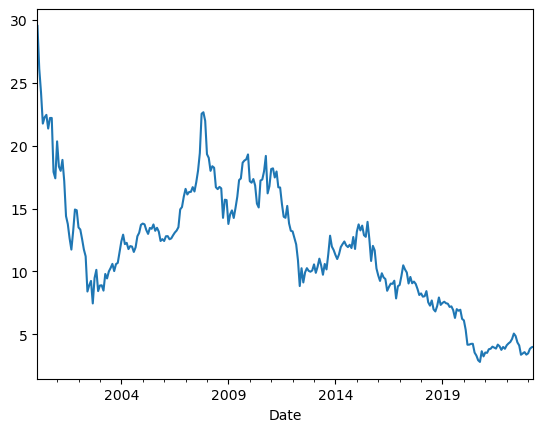

In [3]:
data=yf.download(tickers='TEF.MC',interval='1mo')
data['Close'].plot()


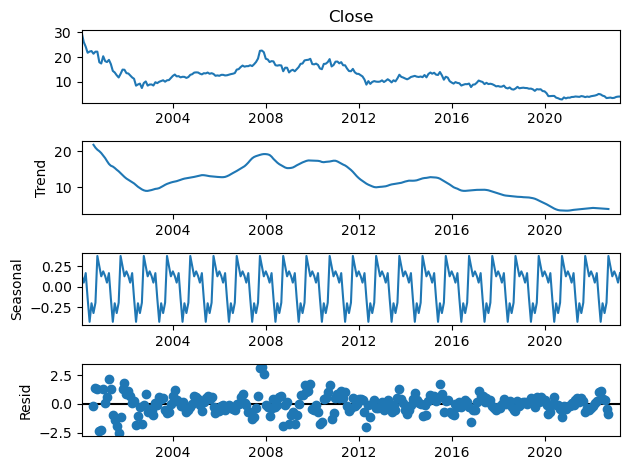

In [4]:
#Entre las herramientas disponibles que aplican métodos estadisticos de manera automática
#los hay de descomposicicón para detectar estacionalidad

#De manera paralela a la aplicación de ARIMA se puede intentar obtener una estimación de lso órdenes de estacionalidad,
#ya que hay opción de que estos valores sean introducidos a la hora de calcular el mejor modelo ARIMA

result= seasonal_decompose(data['Close'])
result.plot();


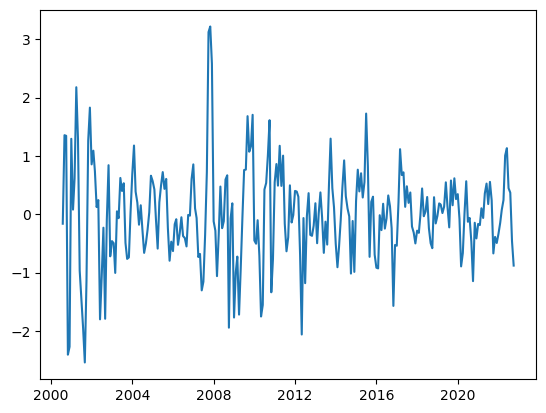

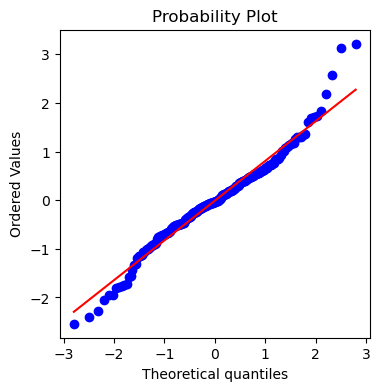

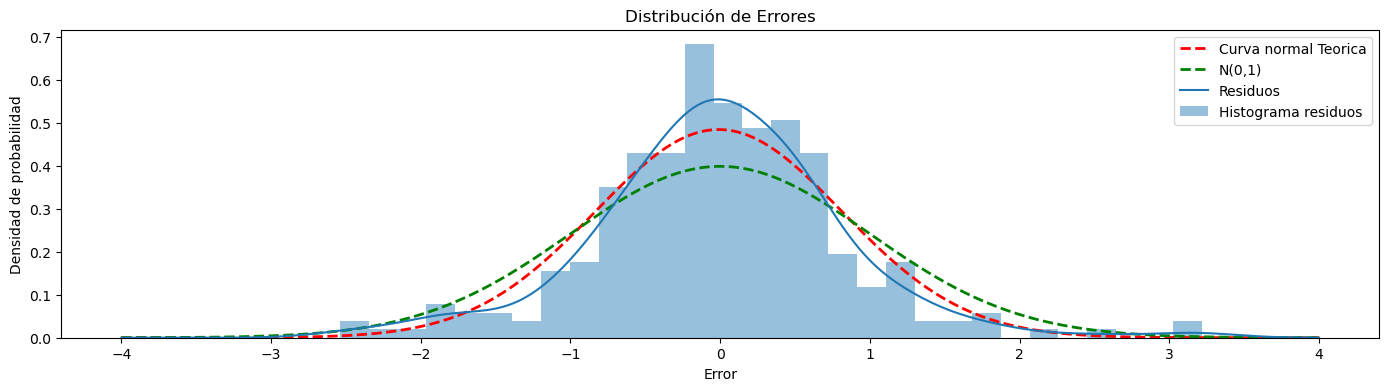

In [5]:
#Calculo de los residuos de la función de descomposicion de tendencia
#Mas abajo se define la funcion par arecibir como parametros test y predicción
#Aqui funciona solo para la descomposision porque maneja solo el df recibido de decompose result
#result= seasonal_decompose(data['Close'])

residuos=result.resid
#Eliminar nulos NaN
residuos = result.resid[~np.isnan(result.resid)]
mediaresiduos=np.mean(residuos)
desvresiduos=np.std(residuos)
n=residuos.shape[0]

#Histograma
#plt.hist(result.resid,bins=50,density=True)
plt.plot(residuos,label='residuo')
plt.figure(figsize=(4,4))
##qqplot

stats.probplot(residuos,plot=plt)

#normal


x = np.linspace(-4,4,num=n)

#Caso que queramos poner como limites los valores minimo y maximo respectivamente de los residuos
#x = np.linspace(int(residuos.min()),int(residuos.max()),num=n)

#Curva normal con paramatros media= media de los residuos  y varianza= varianza de los residuos 
#En caso que los datos siguiesen dirtribucion normal se tendria que parecer a esta curva 
y = stats.norm.pdf(x, mediaresiduos, desvresiduos)

#Curva normal N(0,1)
y2=stats.norm.pdf(x,0,1)
fig, ax = plt.subplots(figsize=(17,4))

# Si el residuo se distribuyese normalmente sería con esta forma N(mediaresiuos,desv residuos**2)
ax.plot(x, y,"--", linewidth=2,c='r',label='Curva normal Teorica')
ax.plot(x, y2,"--", linewidth=2,c='g',label='N(0,1)')
#Calculo de la funcion densidad mediante método
#result.resid.plot.kde(bw_method=0.3,label='Funcion Densidad residuos mediante kde')

#Implemantación manual de la función de densidad de los residuos
densidadresiduos=gaussian_kde(residuos)
densidadresiduos._compute_covariance()
ax.plot(x,densidadresiduos(x),label="Residuos")

ax.hist(x=residuos, density=True, bins=30, color="#3182bd", alpha=0.5,label='Histograma residuos')

ax.set_title('Distribución de Errores')
ax.set_xlabel('Error')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

plt.legend()
plt.show()



In [6]:

'''
El estadístico sigue una chi cuadrado x 2 con 2 grados de libertad y sirve para contrastar
la hipótesis nula Ho de que los residuos siguen una distribución normal Ho: los residuos
estimados se distribuyen normalmente. Si el valor estimado es mayor que el de tablas para un
determinado nivel de confianza, entonces rechazamos la hipótesis nula.
'''
def jarquebera(data,sig):
    jarqueberatest=stats.jarque_bera(data)
    if jarqueberatest[1]<sig:
        print("NO Normalidad según criterio JB")
    else:
        print("Normalidad según criterio JB")

#Para omitir Nulos o Nan en jarquebera
#jarque_bera_test = stats.jarque_bera(result.resid,nan_policy='omit')


In [7]:
jarquebera(residuos,nivelsignificatividad)

NO Normalidad


<Axes: xlabel='Date'>

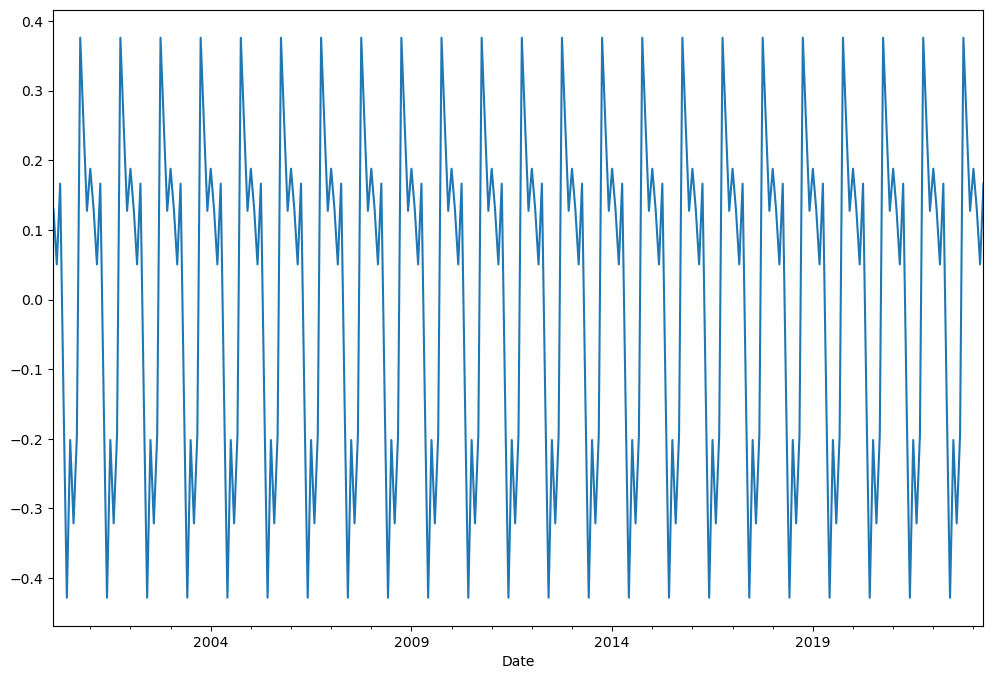

In [8]:
result.seasonal.plot(figsize=(12,8))

In [9]:
porcentajetrain=0.80
porcentajetest=1-porcentajetrain
#porcentajetest=0.3 #prueba raise que test+train no sume la longitud del df
registrostrain=round(len(data)*porcentajetrain)
registrostest=round(len(data)*porcentajetest)
print("Comprobacion")
print ("Tamaño train {0}".format(registrostrain))
print ("Tamaño test {0}".format(registrostest))

if (registrostest+registrostrain) != len(data):
    
    print("Revisar porcentajes de test train")
    print("El total de registros no suma la longitud del df")
    raise ValueError("Revisar porcentajes de test train.¿Pudiese haber error  por redondeo?")
    


Comprobacion
Tamaño train 223
Tamaño test 56


In [10]:
train_data=data.iloc[:registrostrain]
test_data=data.iloc[registrostrain:]

In [11]:
#autoarima=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',start_p=1, start_q=1,max_p=3, max_q=3,max_order=10,seasonal=True,m=mejorperiodo,d=None,trace=True,stepwise=True)
#autoarimasin=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',start_p=1, start_q=1,max_p=3, max_q=3,max_order=10,seasonal=True,m=mejorperiodo,d=None,trace=True,stepwise=True)

autoarima=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',trace=True,stepwise=True,seasonal=True)
autoarima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=630.015, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=637.052, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=639.010, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=638.999, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=637.295, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=634.547, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=633.357, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=627.589, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=629.541, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=629.313, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=629.464, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=627.541, Time=0.07 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=632.286, Time=0.06 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=629.467, Time=0.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=632.5

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  223
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -306.771
Date:                Mon, 24 Apr 2023   AIC                            627.541
Time:                        12:27:48   BIC                            651.360
Sample:                             0   HQIC                           637.158
                                - 223                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2473      0.177     -1.400      0.162      -0.594       0.099
ar.L1         -0.6440      0.143     -4.493      0.000      -0.925      -0.363
ar.L2         -0.7012      0.151     -4.646      0.000      -0.997      -0.405
ma.L1          0.7143      0.160      4.466      0.000       0.401       1.028
ma.L2          0.6666      0.167      4.003      0.000       0.340       0.993
ma.L3          0.1997      0.076      2.637      0.008       0.051       0.348
sigma2         0.9272      0.068     13.606      0.000       0.794       1.061
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                49.35
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
#Intentos detectar el mejor periodo estacional multipliocando el bucle por 12 ya que es frecuencia mensual

periodos=range(1,12)
aicaux=10000
for periodo in periodos:
    #modeloaux=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',start_p=1, start_q=1,max_p=3, max_q=3,max_order=10,seasonal=True,m=periodo,d=None,trace=True,stepwise=True)
    modeloaux=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',d=None,trace=True,stepwise=True,seasonal=True,m=periodo*12)
    #Elimino max_order por usar stepwise (se puede probar mejor resultado)
    #modeloaux=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',seasonal=True,m=periodo,d=None,trace=True,stepwise=True)
    if modeloaux.aic() < aicaux:
        aicaux=modeloaux.aic()
        autoarimaest=modeloaux
        #print("mejor parametro {}".format(autoarima.order))
        #print("Mejor estacionalidad {}".format(autoarima.seasonal_order))
        
    

#autoarima=auto_arima(train_data['interpolated'],error_action='ignore',seasonal=True,m=12)

autoarimaest.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=634.500, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=637.052, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=640.599, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=640.566, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=637.295, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=631.963, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=630.015, Time=0.23 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=631.928, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=634.547, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=633.357, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=627.589, Time=0.20 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=629.553, Time=0.31 sec
 ARIMA(3,1,2)(0,0,1)[12] intercept   : AIC=629.550, Time=0.26 sec
 ARIMA(3,1,2)(1,0,1)[12] intercept   : AIC=631.515, Time=0.46 sec
 ARIMA(3,1,1)(0,0,0)[12] intercep

 ARIMA(2,1,2)(0,0,1)[60] intercept   : AIC=632.014, Time=4.08 sec
 ARIMA(2,1,2)(0,0,0)[60] intercept   : AIC=630.015, Time=0.24 sec
 ARIMA(2,1,2)(1,0,0)[60] intercept   : AIC=632.014, Time=4.03 sec
 ARIMA(1,1,2)(0,0,0)[60] intercept   : AIC=634.547, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[60] intercept   : AIC=633.357, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[60] intercept   : AIC=627.589, Time=0.21 sec
 ARIMA(3,1,2)(1,0,0)[60] intercept   : AIC=629.589, Time=3.57 sec
 ARIMA(3,1,2)(0,0,1)[60] intercept   : AIC=629.589, Time=3.08 sec
 ARIMA(3,1,2)(1,0,1)[60] intercept   : AIC=inf, Time=6.43 sec
 ARIMA(3,1,1)(0,0,0)[60] intercept   : AIC=629.541, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[60] intercept   : AIC=629.313, Time=0.29 sec
 ARIMA(3,1,3)(0,0,0)[60] intercept   : AIC=629.464, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[60] intercept   : AIC=627.541, Time=0.07 sec
 ARIMA(2,1,3)(1,0,0)[60] intercept   : AIC=629.533, Time=1.34 sec
 ARIMA(2,1,3)(0,0,1)[60] intercept   : AIC=629.534, Time=1.67 sec
 ARIMA(2,1,3)(

 ARIMA(3,1,2)(1,0,0)[96] intercept   : AIC=629.586, Time=8.03 sec
 ARIMA(3,1,2)(0,0,1)[96] intercept   : AIC=629.586, Time=6.46 sec
 ARIMA(3,1,2)(1,0,1)[96] intercept   : AIC=631.586, Time=8.04 sec
 ARIMA(3,1,1)(0,0,0)[96] intercept   : AIC=629.541, Time=0.06 sec
 ARIMA(4,1,2)(0,0,0)[96] intercept   : AIC=629.313, Time=0.30 sec
 ARIMA(3,1,3)(0,0,0)[96] intercept   : AIC=629.464, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[96] intercept   : AIC=627.541, Time=0.07 sec
 ARIMA(2,1,3)(1,0,0)[96] intercept   : AIC=629.537, Time=4.05 sec
 ARIMA(2,1,3)(0,0,1)[96] intercept   : AIC=629.538, Time=4.23 sec
 ARIMA(2,1,3)(1,0,1)[96] intercept   : AIC=631.537, Time=9.25 sec
 ARIMA(1,1,3)(0,0,0)[96] intercept   : AIC=632.286, Time=0.07 sec
 ARIMA(2,1,4)(0,0,0)[96] intercept   : AIC=629.467, Time=0.22 sec
 ARIMA(1,1,4)(0,0,0)[96] intercept   : AIC=632.554, Time=0.09 sec
 ARIMA(3,1,4)(0,0,0)[96] intercept   : AIC=630.547, Time=0.33 sec
 ARIMA(2,1,3)(0,0,0)[96]             : AIC=627.697, Time=0.07 sec

Best mode

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  223
Model:             SARIMAX(2, 1, 3)x(2, 0, [], 72)   Log Likelihood                -304.795
Date:                             Mon, 24 Apr 2023   AIC                            625.589
Time:                                     12:52:50   BIC                            652.811
Sample:                                          0   HQIC                           636.580
                                             - 223                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5458      0.161     -3.381      0.001      -0.862      -0.229
ar.L2         -0.6221      0.168     -3.700      0.000      -0.952      -0.293
ma.L1          0.6218      0.175      3.547      0.000       0.278       0.965
ma.L2          0.6017      0.178      3.375      0.001       0.252       0.951
ma.L3          0.2397      0.075      3.216      0.001       0.094       0.386
ar.S.L72       0.1251      0.072      1.727      0.084      -0.017       0.267
ar.S.L144      0.1906      0.135      1.407      0.159      -0.075       0.456
sigma2         0.8823      0.079     11.127      0.000       0.727       1.038
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                49.74
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
#Modelo que se ha elegido automatico probando estacionalidad
autoarimaest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  223
Model:             SARIMAX(2, 1, 3)x(2, 0, [], 72)   Log Likelihood                -304.795
Date:                             Mon, 24 Apr 2023   AIC                            625.589
Time:                                     12:52:50   BIC                            652.811
Sample:                                          0   HQIC                           636.580
                                             - 223                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5458      0.161     -3.381      0.001      -0.862      -0.229
ar.L2         -0.6221      0.168     -3.700      0.000      -0.952      -0.293
ma.L1          0.6218      0.175      3.547      0.000       0.278       0.965
ma.L2          0.6017      0.178      3.375      0.001       0.252       0.951
ma.L3          0.2397      0.075      3.216      0.001       0.094       0.386
ar.S.L72       0.1251      0.072      1.727      0.084      -0.017       0.267
ar.S.L144      0.1906      0.135      1.407      0.159      -0.075       0.456
sigma2         0.8823      0.079     11.127      0.000       0.727       1.038
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                49.74
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.64
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
#odeloaux=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',trace=True,stepwise=True,seasonal=True)
#modeloaux=auto_arima(train_data['Close'],error_action='ignore',information_criterion='aic',start_p=1, start_q=1, start_P=1, start_Q=1,max_p=5, max_q=5, max_P=5,max_Q=5,max_D=10,seasonal=True,m=12*4,trace=True,stepwise=True)

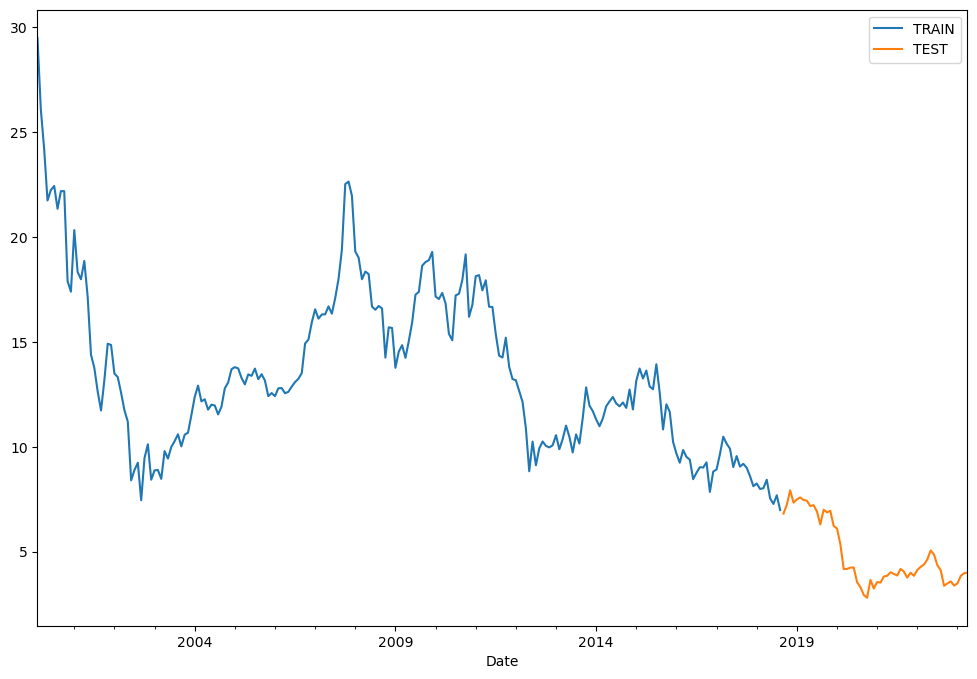

In [15]:
train_data['Close'].plot(legend=True,label='TRAIN')
test_data['Close'].plot(legend=True,label='TEST',figsize=(12,8));

In [16]:
predicciontestmat=autoarima.predict(n_periods=registrostest)
predicciontestmatest=autoarimaest.predict(n_periods=registrostest)
#pruebamat=modeloaux.predict(n_periods=registrostest)

In [17]:
predicciontest=pd.DataFrame(data=predicciontestmat,index=test_data.index,columns=['Close'])  
predicciontestest=pd.DataFrame(data=predicciontestmatest,index=test_data.index,columns=['Close']) 
#prueba=pd.DataFrame(data=pruebamat,index=test_data.index,columns=['Close']) 

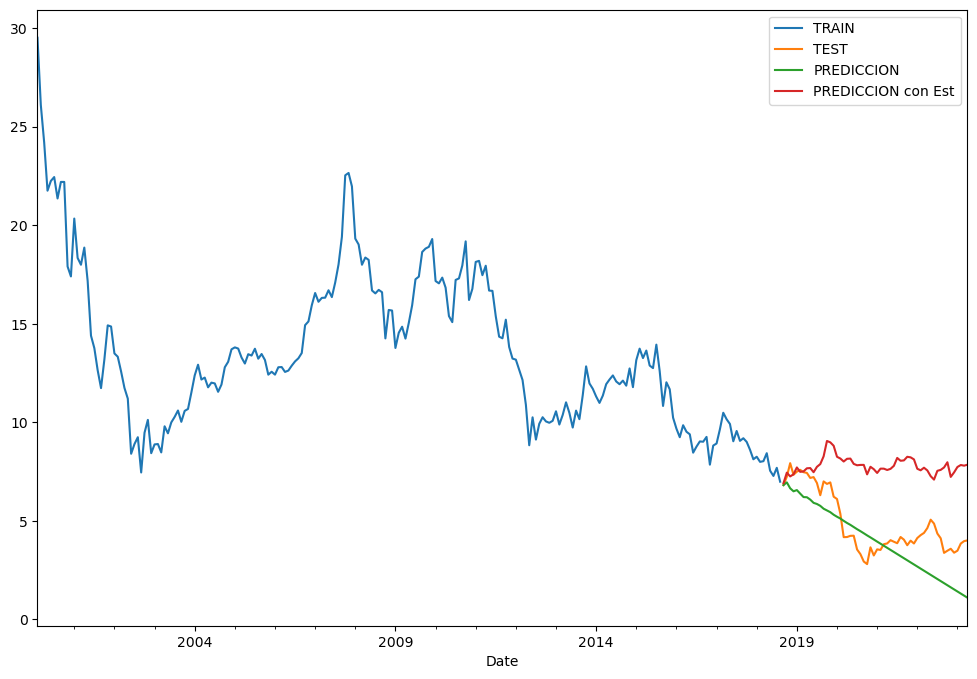

In [18]:
train_data['Close'].plot(legend=True,label='TRAIN')
test_data['Close'].plot(legend=True,label='TEST',figsize=(12,8))
predicciontest['Close'].plot(legend=True,label='PREDICCION');
predicciontestest['Close'].plot(legend=True,label='PREDICCION con Est');
#prueba['Close'].plot(legend=True,label='Prueba ST');

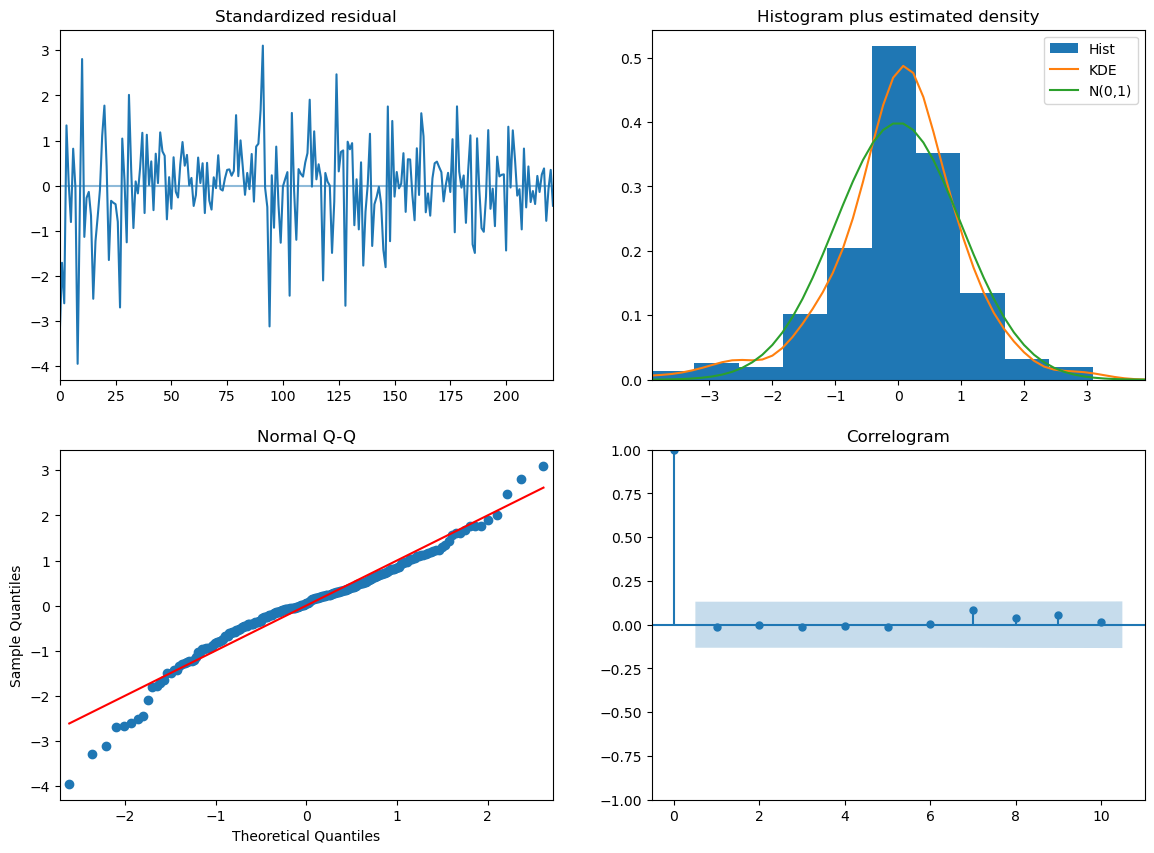

In [20]:
autoarima.plot_diagnostics(figsize=(14,10))
plt.show()



In [ ]:
#Genaralizacion de función para evaluación de normalidad

In [58]:
def residuospredic (dftest,dfpredic):

    residuos=np.array(test_data['Close']-dfpredic['Close'])
#Eliminar nulos NaN
    #residuo = residuos[~np.isnan(result.resid)]

    mediaresiduos=residuos.mean()
    desvresiduos=np.std(residuos)
    n=residuos.shape[0]

#Histograma
#plt.hist(result.resid,bins=50,density=True)
    plt.plot(residuos,label='residuo')
    plt.figure(figsize=(4,4))
##qqplot

    stats.probplot(residuos,plot=plt)

#normal


    x = np.linspace(-4,4,num=n)

#Caso que queramos poner como limites los valores minimo y maximo respectivamente de los residuos
#x = np.linspace(int(residuos.min()),int(residuos.max()),num=n)

#Curva normal con paramatros media= media de los residuos  y varianza= varianza de los residuos 
#En caso que los datos siguiesen dirtribucion normal se tendria que parecer a esta curva 
    y = stats.norm.pdf(x, mediaresiduos, desvresiduos)

#Curva normal N(0,1)
    y2=stats.norm.pdf(x,0,1)
    fig, ax = plt.subplots(figsize=(17,4))

# Si el residuo se distribuyese normalmente sería con esta forma N(mediaresiuos,desv residuos**2)
    ax.plot(x, y,"--", linewidth=2,c='r',label='Curva normal Teorica')
    ax.plot(x, y2,"--", linewidth=2,c='g',label='N(0,1)')
#Calculo de la funcion densidad mediante método
#result.resid.plot.kde(bw_method=0.3,label='Funcion Densidad residuos mediante kde')

#Implemantación manual de la función de densidad de los residuos
    densidadresiduos=gaussian_kde(residuos)
    densidadresiduos._compute_covariance()
    ax.plot(x,densidadresiduos(x),label="Residuos")

    ax.hist(x=residuos, density=True, bins=30, color="#3182bd", alpha=0.5,label='Histograma residuos')

    ax.set_title('Distribución de Errores')
    ax.set_xlabel('Error')
    ax.set_ylabel('Densidad de probabilidad')
    ax.legend();

    plt.legend()
    plt.show()
    
    #jarquebera(residuos,nivelsignificatividad)

    return jarquebera(residuos,nivelsignificatividad)

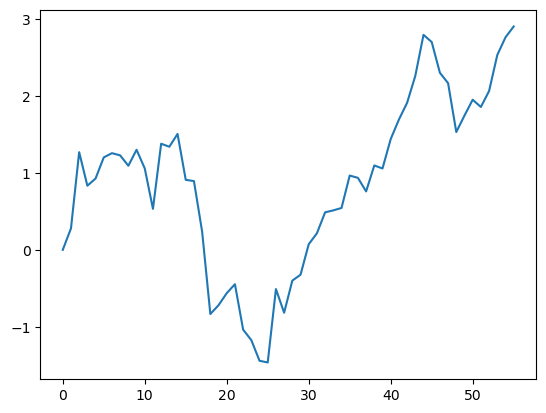

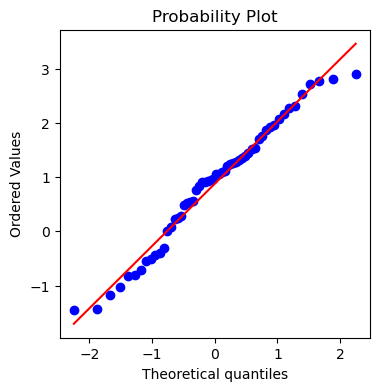

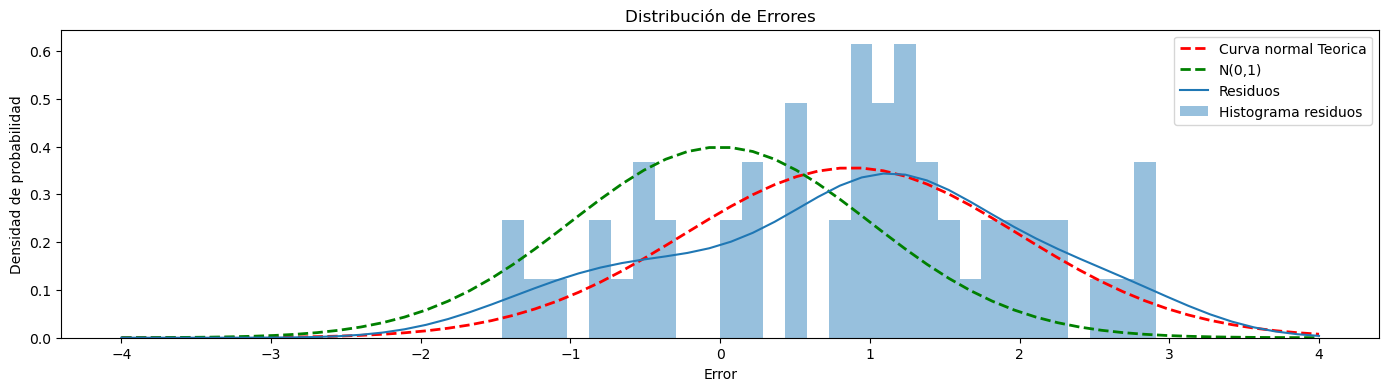

Normalidad


In [60]:
residuospredic(test_data,predicciontest)

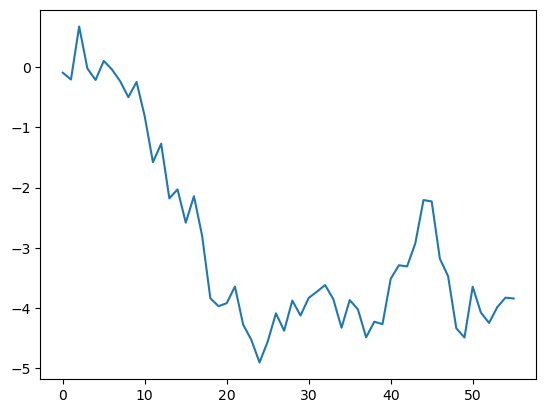

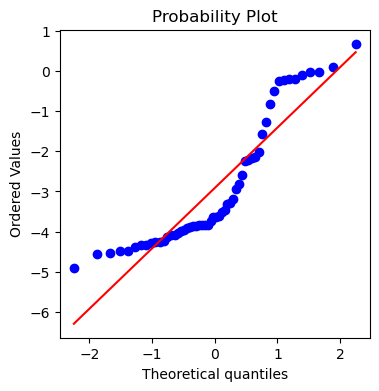

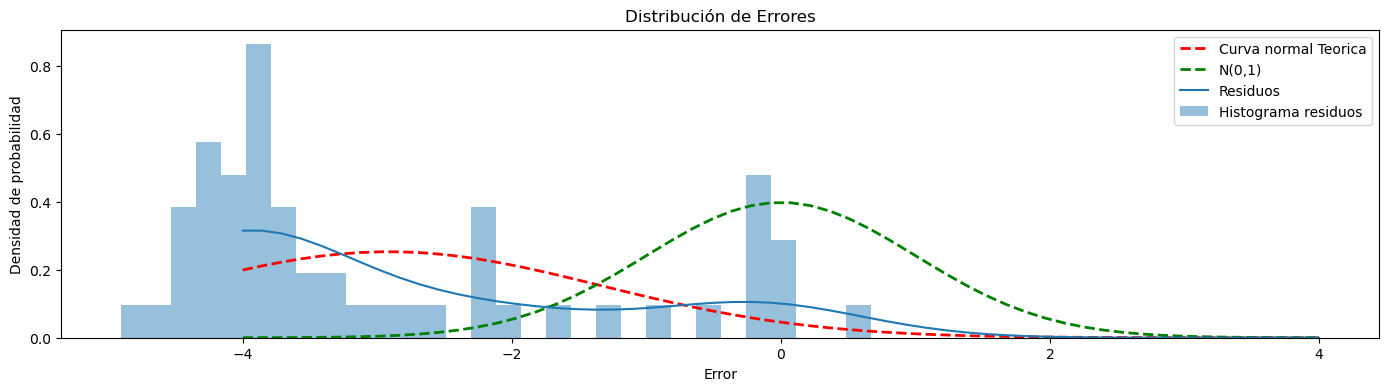

NO Normalidad


In [59]:
residuospredic(test_data,predicciontestest)